1% of women at age forty who participate in routine screening have breast cancer. 80% of women with breast cancer will get positive mammographies. 9.6% of women without breast cancer will also get positive mammographies. 

A woman in this age group had a positive mammography in a routine screening.

What is the probability that she actually has breast cancer?

- P(A): 40 y/o woman, routine screening, has breast cancer = 1%
- P(A|B): has breast cancer, given positive mammogram = 80%
- P(B): positive mammogram, does not have breast cancer = 9.6%

Bayes: P(y|x) = (P(y)P(x|y))/P(x)

- P(y) 
    - a priori
    - what we already know (target variable)
- P(x|y)
    - coefficients
- P(x)
    - probability of features


- must be supervised because we need a priori information

## Two types of Bayes
**Multinomial**
- how frequently does a feature show up?

**Bernoulli**
- is a feature present?

In [4]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import naive_bayes  ## dedicated naive bayes module in sklearn

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

critics = pd.read_csv('../DAT18NYC/data/rt_critics.csv') ## Rotten Tomatoes data

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Math is great', 'Math is really great', 'Exciting exciting Math']

## CountVectorizer?
## converts text inputs to a sparse matrix of token counts
## sparse matrix contains data only for present data

## Like the learners in sklearn, CountVectorizer is a class; so `vectorizer` below represents an instance of that object.
vectorizer = CountVectorizer(ngram_range=(1,2)) ## range defines upper and lower limit for n-grams to look for

## call `fit` to build the vocabulary
vectorizer.fit(text)

## then, use `get_feature_names` to return the tokens
print vectorizer.get_feature_names()

## finally, call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

[u'exciting', u'exciting exciting', u'exciting math', u'great', u'is', u'is great', u'is really', u'math', u'math is', u'really', u'really great']


In [12]:
print 'Sparse Matrix'
print x # A compressed version; the "sparse" matrix.
print type(x) # type is from scipy, a library we've spoken very little of, but is pretty fantastic.
print

print 'Matrix'
x_back = x.toarray()
print x_back
print

print 'Matrix as DataFrame, with headers from feature names'
pd.DataFrame(x_back, columns=vectorizer.get_feature_names())

Sparse Matrix
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 7)	1
  (0, 8)	1
  (1, 3)	1
  (1, 4)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 9)	1
  (1, 10)	1
  (2, 0)	2
  (2, 1)	1
  (2, 2)	1
  (2, 7)	1
<class 'scipy.sparse.csr.csr_matrix'>

Matrix
[[0 0 0 1 1 1 0 1 1 0 0]
 [0 0 0 1 1 0 1 1 1 1 1]
 [2 1 1 0 0 0 0 1 0 0 0]]

Matrix as DataFrame, with headers from feature names


,exciting,exciting exciting,exciting math,great,is,is great,is really,math,math is,really,really great
0,0,0,0,1,1,1,0,1,1,0,0
1,0,0,0,1,1,0,1,1,1,1,1
2,2,1,1,0,0,0,0,1,0,0,0


In [14]:
## X is a (nreview, nwords) array. Each row corresponds to a bag-of-words representation for a single review. This will be the input to the model.
## y is a nreview-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired output

## example review
print critics.quote[2]

A winning animated feature that has something for everyone on the age spectrum.


In [17]:
## create a vector where each row is bag-of-words for a single quote vectorizer is now going to forget the original feature set. 
## What types of ngrams should we be getting given the settings we used when creating the vectorizer instance?
rotten_vectorizer = vectorizer.fit(critics.quote) 
x = vectorizer.fit_transform(critics.quote)

# Create an array where each element encodes whether the array is Fresh or Rotten
y = (critics.fresh == 'fresh').values.astype(int)

In [23]:
## 1. accepts a classifer (bayes, logisitic regression, linear regression) from sklearn 
## 2. computes the accuracy measure for a random train and test split classifier an sklearn class
def train_and_measure(classifier, x, y, tsize):
    from sklearn import cross_validation
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=tsize, random_state=1234)
    clf = classifier.fit(xtrain, ytrain)

    #Print the accuracy on the test and training dataset
    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)
    print classifier
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print
    
train_and_measure(naive_bayes.MultinomialNB(), x, y, 0.1)

x_ones = (x >= 1) # recall that a bernoulli interpretation will only work with 1s and 0s, or binary data.
train_and_measure(naive_bayes.BernoulliNB(), x_ones, y, 0.1)

# and for the heck of it:
from sklearn import linear_model
train_and_measure(linear_model.LogisticRegression(), x, y, 0.1) ## overfit

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accuracy on training data: 0.99
Accuracy on test data:     0.76

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Accuracy on training data: 0.90
Accuracy on test data:     0.67

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
Accuracy on training data: 1.00
Accuracy on test data:     0.77



10 folds
shuffle: True
random state: 1234
mean accuracy: 0.781198865655
std accuracy: 0.011261376418


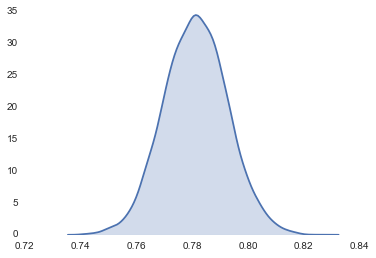

In [47]:
import numpy as np
from sklearn import cross_validation

def fn_kfold(num_folds, x, y, shuff_tf, rand, classifier):
    kfold = cross_validation.KFold(n=x.shape[0], n_folds=num_folds, shuffle=shuff_tf, random_state=rand) ## breaks up set into k "folds"

    train_acc = []
    test_acc = []
    for train_index, test_index in kfold: ## for each times 
        clf = classifier.fit(x[train_index], y[train_index])
        train_acc.append(clf.score(x[train_index], y[train_index]))
        test_acc.append(clf.score(x[test_index], y[test_index]))

    print num_folds, 'folds'
    print 'shuffle:', shuff_tf
    print 'random state:', rand
    print 'mean accuracy:', np.array(test_acc).mean()
    print 'std accuracy:', np.array(test_acc).std()

    plt.figure()
    sns.kdeplot(np.random.normal(loc=np.array(test_acc).mean(), scale=np.array(test_acc).std(), size=10000), shade=True)
    
fn_kfold(10, x, y, True, 1234, naive_bayes.MultinomialNB())    

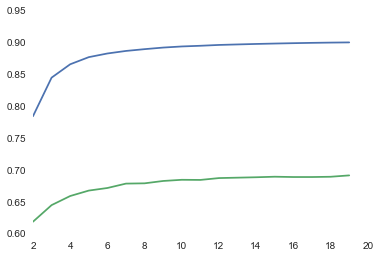

In [46]:
## how do we find k?

def find_k(classifier, x, y, max_k):
    from sklearn import cross_validation
    import numpy as np
    k_train_acc = []
    k_test_acc = []
    for i in range(2, max_k): ## k between 2 and 20
        kfold = cross_validation.KFold(n=x.shape[0], n_folds=i, shuffle=True, random_state=1234)
        test_acc, train_acc = [], []
        for train_index, test_index in kfold:
            clf = classifier.fit(x[train_index], y[train_index])
            train_acc.append(clf.score(x[train_index], y[train_index]))
            test_acc.append(clf.score(x[test_index], y[test_index]))
        k_train_acc.append(np.array(train_acc).mean())
        k_test_acc.append(np.array(test_acc).mean())

    plt.figure()
    plt.plot(range(2, max_k), k_train_acc)
    plt.plot(range(2, max_k), k_test_acc)
    
find_k(naive_bayes.BernoulliNB(), x_ones, y, 20)
find_k(naive_bayes.BernoulliNB(), x_ones, y, 20)

In [48]:
from sklearn.metrics import confusion_matrix
from __future__ import division

y_true = y
y_pred = clf.predict(x)

'''
Note! the confusion matrix here will be [0 1],
not [1, 0] as in the above image.
'''
conf = confusion_matrix(y_true, y_pred)

print conf

print clf.score(x, y)
print conf[0, 0] / (conf[0, 0] + conf[0, 1])
print conf[1, 1] / (conf[1, 0] + conf[1, 1])

[[5264  195]
 [  97 8516]]
0.979249573621
0.96427917201
0.988737954255


In [49]:
# Review errors
prob = clf.predict_proba(x)[:, 0]
bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print "Mis-predicted Rotten quotes"
print '---------------------------'
for row in bad_rotten:
    print critics[y == 0].quote.irow(row)
    print

print "Mis-predicted Fresh quotes"
print '--------------------------'
for row in bad_fresh:
    print critics[y == 1].quote.irow(row)
    print

Mis-predicted Rotten quotes
---------------------------
The Ref is one of those rare movies that seem to have everything going for it -- a promising director, terrific actors and an original, unapologetically grown-up script -- yet somehow still turns out to be a phenomenal drag.

A complicated film that never really successfully yokes together the themes of money-making and sexuality, it reveals both Kazan's operatic sensibility and his inability to follow an argument rigorously through.

The people behind this film would not recognize complex, honest emotion if it hit them in the face with a frying pan.

At three hours, Jackson's Kong is too bloated and digressive to match the pure adrenaline of the first film, perhaps the finest B-movie ever made.

Based on William Goldman's novel, this is a post-modern fairy tale that challenges and affirms the conventions of a genre that may not be flexible enough to support such horseplay.

Mis-predicted Fresh quotes
--------------------------
As